In [1]:
"""
Quantum–Classical Hybrid DCGAN (qGAN) for MNIST
Author: Varun E
Description:
  - Combines a classical generator with a quantum-augmented discriminator.
  - Uses a 4-qubit parameterized quantum circuit (PQC) layer in the discriminator.
  - Runs fully on CPU via PennyLane's default.qubit simulator.
"""

# -----------------------------
# 📦 Imports
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pennylane as qml
from pennylane import numpy as np
import os

# -----------------------------
# ⚙️ Configurations
# -----------------------------
BATCH_SIZE = 64
EPOCHS = 15            # reduce for faster testing
LR = 0.0002
Z_DIM = 100
IMG_CHANNELS = 1
N_QUBITS = 4           # number of qubits for quantum circuit
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "results_qgan"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 📚 Data Loading
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# -----------------------------
# ⚛️ Quantum Circuit Definition
# -----------------------------
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical inputs as qubit rotations
    for i in range(N_QUBITS):
        qml.RY(inputs[i], wires=i)

    # Entanglement
    for i in range(N_QUBITS - 1):
        qml.CNOT(wires=[i, i + 1])

    # Learnable rotation layer
    for i in range(N_QUBITS):
        qml.RY(weights[i], wires=i)

    # Expectation values as output
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# -----------------------------
# 🧠 Quantum Layer
# -----------------------------
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(N_QUBITS))

    def forward(self, x):
        # Flatten image & reduce to N_QUBITS features
        x = x.view(x.size(0), -1)
        x_reduced = x[:, :N_QUBITS]

        outputs = []
        for sample in x_reduced:
            out = quantum_circuit(sample, self.weights)
            # 🔧 FIX: convert list → torch tensor
            out_tensor = torch.tensor(out, dtype=torch.float32).to(x.device)
            outputs.append(out_tensor)

        return torch.stack(outputs)

# -----------------------------
# 🧩 Generator (Classical)
# -----------------------------
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# -----------------------------
# ⚛️ Discriminator (Quantum + Classical)
# -----------------------------
class HybridDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = QuantumLayer()
        self.fc = nn.Sequential(
            nn.Linear(N_QUBITS, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.q_layer(x)
        return self.fc(x)

# -----------------------------
# 🚀 Training
# -----------------------------
gen = Generator(Z_DIM).to(DEVICE)
disc = HybridDiscriminator().to(DEVICE)

criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))

print("🚀 Training Quantum-Classical DCGAN (qGAN)...")

for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(DEVICE)
        batch_size = real.size(0)

        # --- Train Discriminator ---
        noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
        fake = gen(noise)
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

        disc_real = disc(real)
        lossD_real = criterion(disc_real, real_labels)

        disc_fake = disc(fake.detach())
        lossD_fake = criterion(disc_fake, fake_labels)

        lossD = (lossD_real + lossD_fake) / 2
        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # --- Train Generator ---
        disc_output = disc(fake)
        lossG = criterion(disc_output, real_labels)

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{EPOCHS}]  LossD: {lossD.item():.4f}  LossG: {lossG.item():.4f}")

    # Save samples
    with torch.no_grad():
        test_noise = torch.randn(16, Z_DIM).to(DEVICE)
        samples = gen(test_noise).cpu()
        save_image(samples * 0.5 + 0.5, f"{OUT_DIR}/qgan_epoch{epoch}.png", nrow=4)

print("✅ qGAN Training complete. Results saved in 'results_qgan/'")

100.0%
100.0%
100.0%
100.0%
C:\Users\deepa\AppData\Local\Temp\ipykernel_34660\3786199118.py:86: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  out_tensor = torch.tensor(out, dtype=torch.float32).to(x.device)


🚀 Training Quantum-Classical DCGAN (qGAN)...
Epoch [1/15]  LossD: 0.5209  LossG: 0.9457
Epoch [2/15]  LossD: 0.2904  LossG: 1.4559
Epoch [3/15]  LossD: 0.1101  LossG: 2.2723
Epoch [4/15]  LossD: 0.0350  LossG: 3.6052
Epoch [5/15]  LossD: 0.0157  LossG: 4.3905
Epoch [6/15]  LossD: 0.0076  LossG: 5.1208
Epoch [7/15]  LossD: 0.0041  LossG: 5.7522
Epoch [8/15]  LossD: 0.0023  LossG: 6.3227
Epoch [9/15]  LossD: 0.0014  LossG: 6.8167
Epoch [10/15]  LossD: 0.0007  LossG: 7.5599
Epoch [11/15]  LossD: 0.0005  LossG: 7.9435
Epoch [12/15]  LossD: 0.0003  LossG: 8.5563
Epoch [13/15]  LossD: 0.0001  LossG: 9.3073
Epoch [14/15]  LossD: 0.0001  LossG: 9.5822
Epoch [15/15]  LossD: 0.0001  LossG: 10.1726
✅ qGAN Training complete. Results saved in 'results_qgan/'


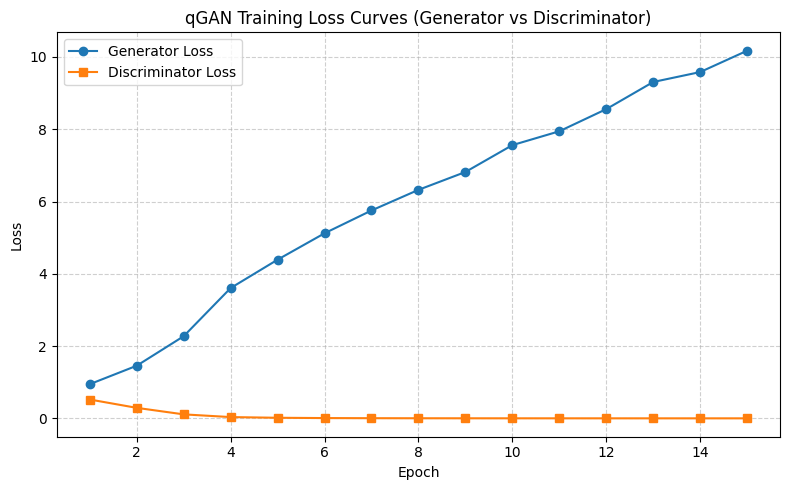

In [2]:
import matplotlib.pyplot as plt

# === Loss values from your qGAN training log ===
lossD = [0.5209, 0.2904, 0.1101, 0.0350, 0.0157, 0.0076, 0.0041, 0.0023,
         0.0014, 0.0007, 0.0005, 0.0003, 0.0001, 0.0001, 0.0001]

lossG = [0.9457, 1.4559, 2.2723, 3.6052, 4.3905, 5.1208, 5.7522, 6.3227,
         6.8167, 7.5599, 7.9435, 8.5563, 9.3073, 9.5822, 10.1726]

epochs = range(1, len(lossD) + 1)

# === Plot Loss Curves ===
plt.figure(figsize=(8,5))
plt.plot(epochs, lossG, marker='o', label="Generator Loss", color='tab:blue')
plt.plot(epochs, lossD, marker='s', label="Discriminator Loss", color='tab:orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("qGAN Training Loss Curves (Generator vs Discriminator)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

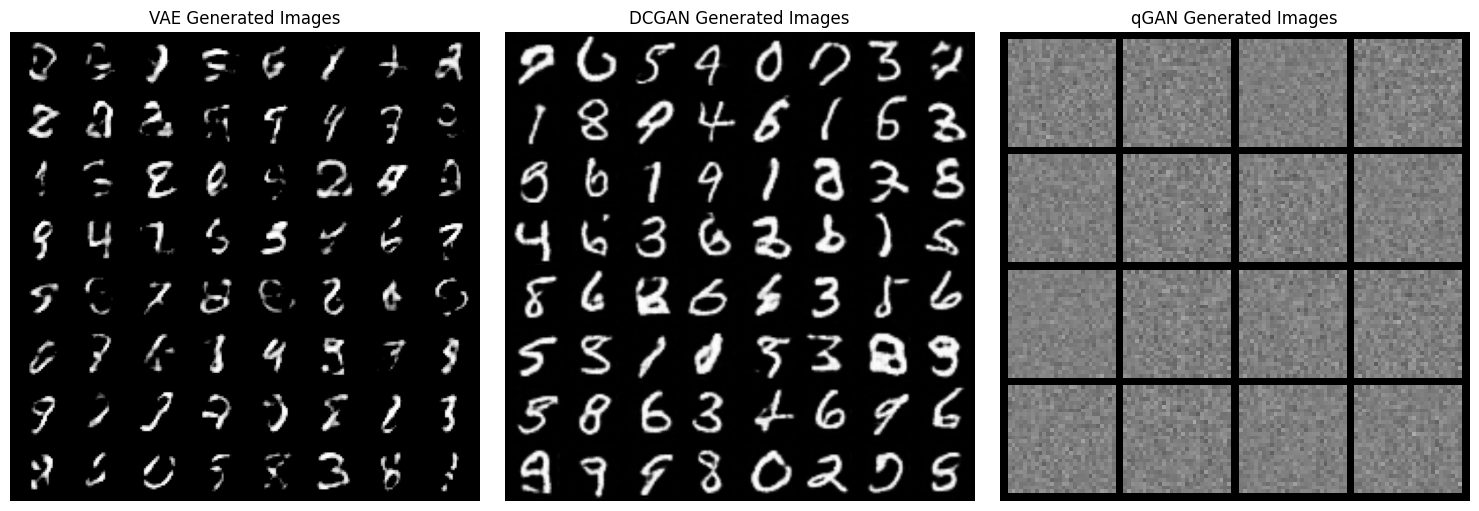

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

vae_img = Image.open("results_vae/sample_epoch20.png")
gan_img = Image.open("results_dcgan/sample_epoch30.png")
qgan_img = Image.open("results_qgan/qgan_epoch15.png")

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("VAE Generated Images")
plt.imshow(vae_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("DCGAN Generated Images")
plt.imshow(gan_img)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("qGAN Generated Images")
plt.imshow(qgan_img)
plt.axis("off")

plt.tight_layout()
plt.show()